In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [13]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')

In [14]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [15]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [16]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

<AxesSubplot:title={'center':'PJME Consumption hourly'}, xlabel='Datetime'>

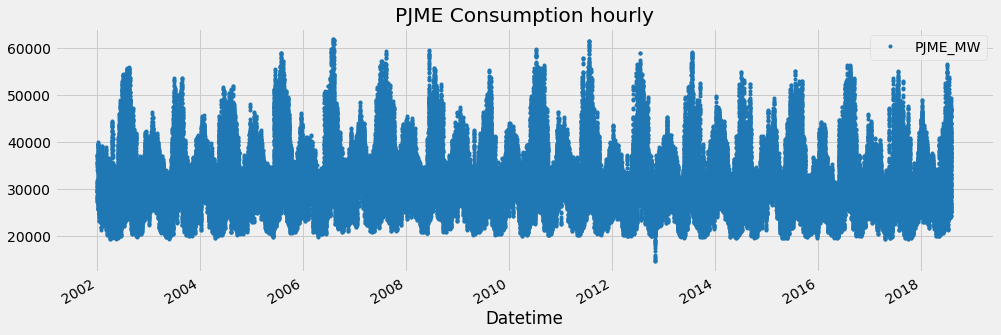

In [17]:
df.plot(style = '.', figsize = (15, 5), color = color_pal[0], title = 'PJME Consumption hourly')

In [20]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

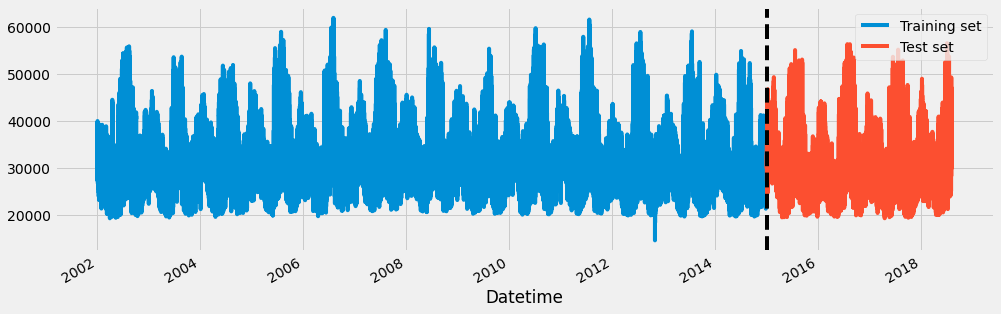

In [25]:
fig, ax = plt.subplots(figsize= (15, 5))
train.plot(ax = ax, label = 'Train')
test.plot(ax = ax, label = 'Test')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training set', 'Test set'])
plt.show()

<AxesSubplot:xlabel='Datetime'>

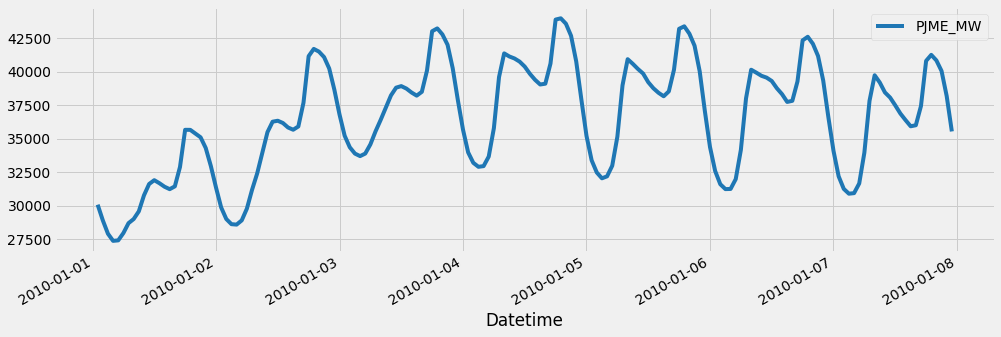

In [28]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize = (15, 5), color = color_pal[0])

In [89]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df


In [109]:
df = create_features(df)

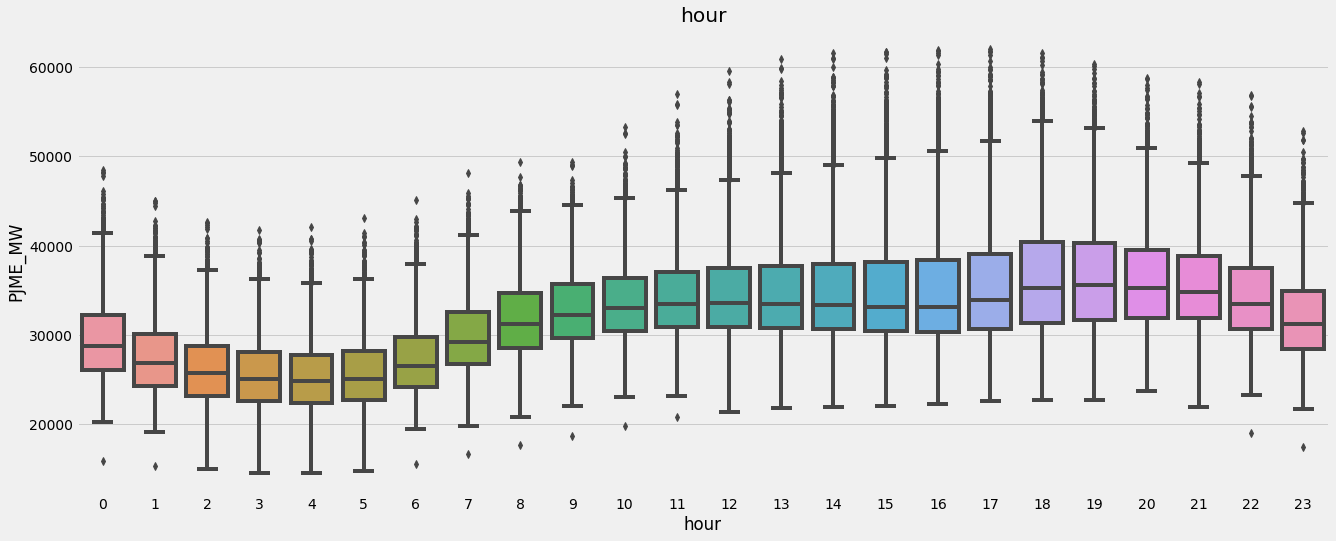

In [34]:
fig, ax = plt.subplots(figsize = (20, 8))
sns.boxplot(data = df, x = 'hour', y='PJME_MW')
ax.set_title('hour')
plt.show()

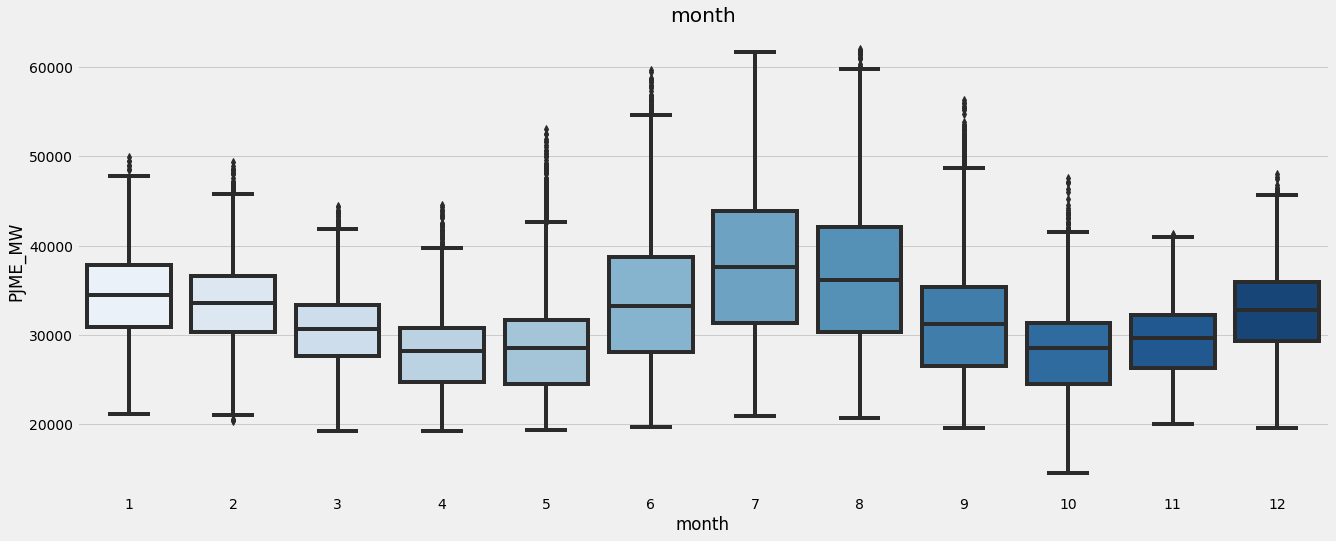

In [36]:
fig, ax = plt.subplots(figsize = (20, 8))
sns.boxplot(data = df, x = 'month', y='PJME_MW', palette = 'Blues')
ax.set_title('month')
plt.show()

In [39]:
train = create_features(train)
test = create_features(test)

In [110]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'prediction', 'lag1', 'lag2', 'lag3', 'isFuture', 'dayofmonth',
       'weekofyear'],
      dtype='object')

In [41]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [42]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [47]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = True)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[1]	validation_0-rmse:32279.88735	validation_1-rmse:31332.60350
[2]	validation_0-rmse:31961.14360	validation_1-rmse:31014.27357
[3]	validation_0-rmse:31645.62525	validation_1-rmse:30699.10021
[4]	validation_0-rmse:31333.30788	validation_1-rmse:30385.92606
[5]	validation_0-rmse:31024.14316	validation_1-rmse:30075.82644
[6]	validation_0-rmse:30718.10796	validation_1-rmse:29769.05547
[7]	validation_0-rmse:30415.17979	validation_1-rmse:29465.13991
[8]	validation_0-rmse:30115.31200	validation_1-rmse:29164.62813
[9]	validation_0-rmse:29818.48171	validation_1-rmse:28866.85195
[10]	validation_0-rmse:29524.66621	validation_1-rmse:28571.74321
[11]	validation_0-rmse:29233.82326	validation_1-rmse:28280.36822
[12]	validation_0-rmse:28945.84624	validation_1-rmse:27991.28725
[13]	validation_0-rmse:28660.79477	validation_1-rmse:27705.25177
[14]	validation_0-rmse:28378.63482	validation_1-rmse:27422.93837
[15]	validation_0-rmse:28099.33236	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [49]:
fi = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns = ['importance'])

<AxesSubplot:title={'center':'Feature Importance'}>

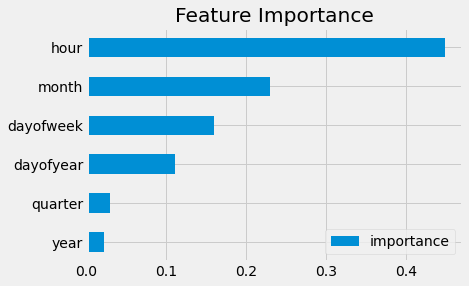

In [51]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
# Feature importance is not exactly reliable when you have highly correlated data so its better to check the autocorrelation or use automated packages that help out

In [53]:
test['prediction'] = reg.predict(X_test)

In [56]:
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

Text(0.5, 1.0, 'Prediction and Actual data')

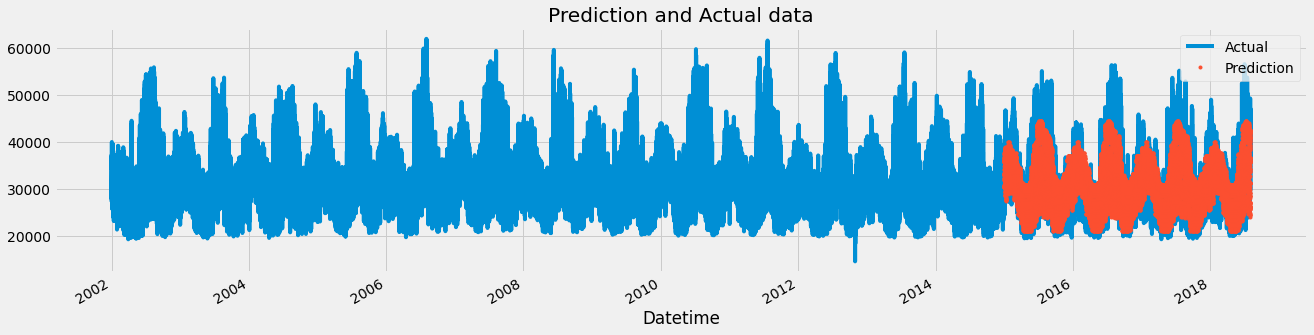

In [58]:
ax = df[['PJME_MW']].plot(figsize = (20, 5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Actual', 'Prediction'])
ax.set_title('Prediction and Actual data')

Text(0.5, 1.0, 'Prediction and Actual data')

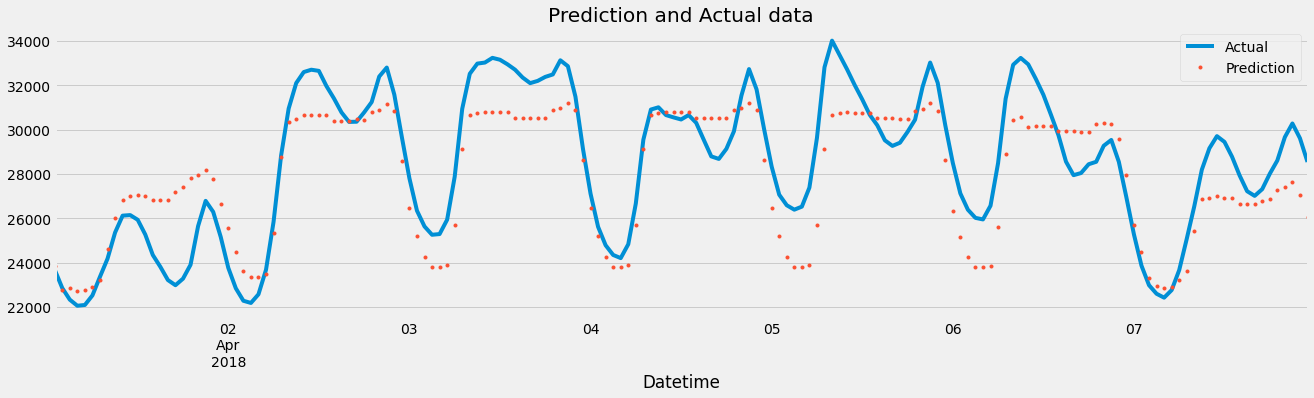

In [62]:
# df[['PJME_MW']].loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize = (15, 5), color = color_pal[0])

ax = df[['PJME_MW']].loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')].plot(figsize = (20, 5))
df['prediction'].loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')].plot(ax = ax, style = '.')
plt.legend(['Actual', 'Prediction'])
ax.set_title('Prediction and Actual data')

In [64]:
rmse = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'rmse: {rmse: 0.2f}')

rmse:  3714.53


In [65]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [67]:
test['date'] = test.index.date

In [69]:
test.groupby('date')['error'].mean().sort_values(ascending= False).head(5)
# average error for each day

date
2016-08-13    14559.813965
2016-08-14    14393.350911
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
Name: error, dtype: float64

In [70]:
test.groupby('date')['error'].mean().sort_values(ascending= False).tail(5)


date
2016-12-08    480.121663
2015-03-10    444.994792
2016-04-04    432.775065
2016-05-01    420.460286
2016-09-27    376.074544
Name: error, dtype: float64

In [122]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

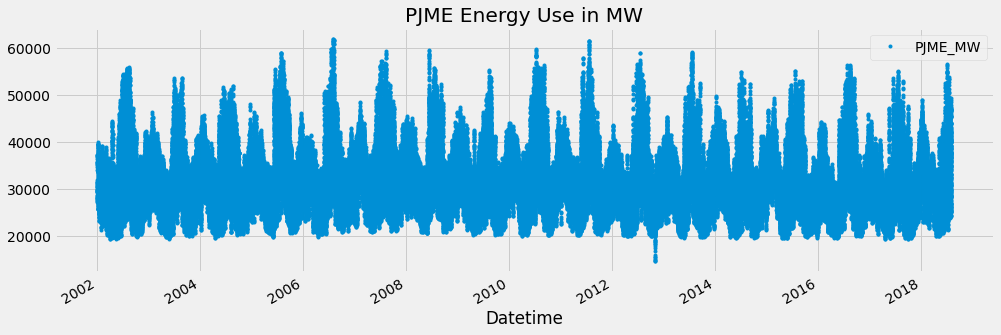

In [123]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

<AxesSubplot:ylabel='Frequency'>

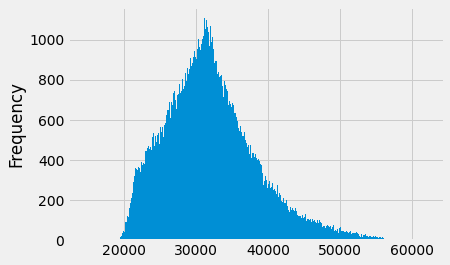

In [124]:
df['PJME_MW'].plot(kind = 'hist', bins = 500)

<AxesSubplot:xlabel='Datetime'>

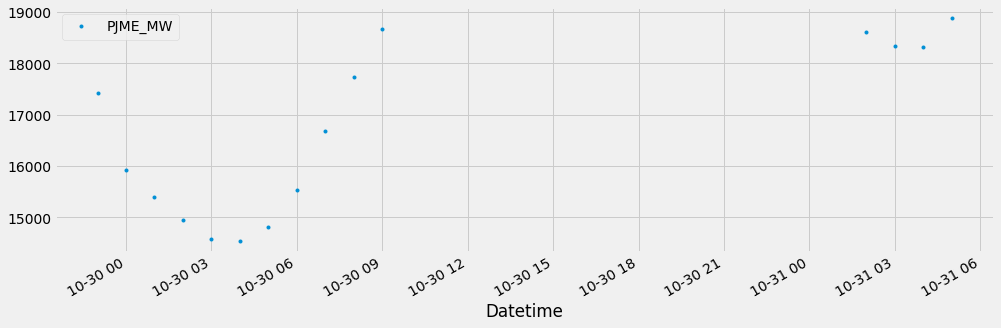

In [125]:
df[['PJME_MW']].query('PJME_MW < 19_000').plot(figsize = (15, 5), style = '.')

In [126]:
df = df.query('PJME_MW > 19_000').copy()

In [127]:
df[df['PJME_MW'] < 19_000]

,PJME_MW
Datetime,


In [128]:
from sklearn.model_selection import TimeSeriesSplit

In [129]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

In [130]:
tss.split(df)

<generator object TimeSeriesSplit.split at 0x7f92a19d5e50>

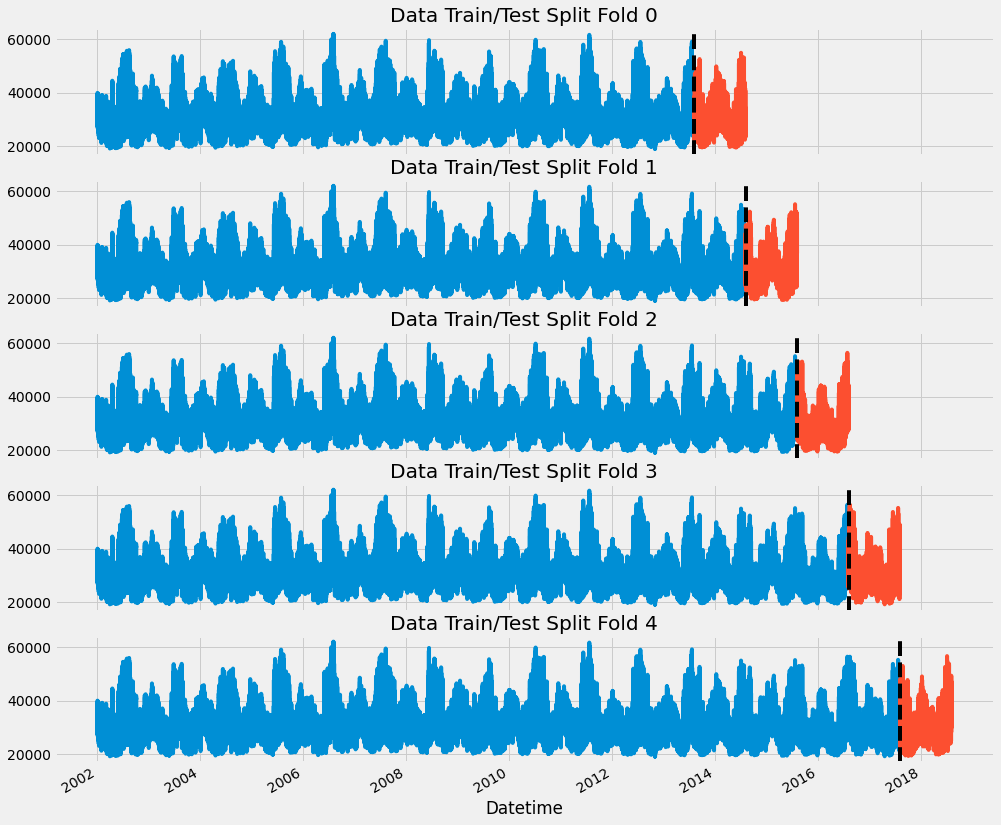

In [131]:
fig, axs = plt.subplots(5, 1, figsize = (15, 15), sharex = True)
fold = 0
for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    train['PJME_MW'].plot(ax = axs[fold], label = 'Training set', title = f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax = axs[fold], label = 'Testing set')
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold+=1
plt.show()


In [132]:
def create_features(df):
   
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [133]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [134]:
df = add_lags(df)

In [135]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0


In [136]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [137]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0


In [138]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()
fold = 0
preds = []
scores = []
for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','lag1','lag2','lag3']
    TARGET = 'PJME_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', n_estimators = 1000, early_stopping_rounds = 50, objective='reg:linear', 
                          max_depth = 3, learning_rate = 0.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[20:18:39] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.15798	validation_1-rmse:11907.12157
[200]	validation_0-rmse:5744.94936	validation_1-rmse:5353.51632
[300]	validation_0-rmse:3868.56640	validation_1-rmse:3898.53908
[400]	validation_0-rmse:3430.63336	validation_1-rmse:3758.24522
[451]	validation_0-rmse:3355.51655	validation_1-rmse:3763.34980
[20:18:59] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.57784	validation_1-rmse:12221.41614
[200]	validation_0-rmse:5755.56552	validation_1-rmse:5655.33259
[300]	validation_0-rmse:3904.98895	validation_1-rmse:3931.65967
[400]	validation_0-rmse:3476.76871	validation_1-rmse:3598.75393
[500]	validation_0-rmse:3355.49568	validation_1-rmse:3

In [139]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[20:21:00] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.43427
[200]	validation_0-rmse:5752.11136
[300]	validation_0-rmse:3971.36505
[400]	validation_0-rmse:3571.35729
[499]	validation_0-rmse:3456.28762


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [140]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [141]:
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [142]:
future_w_features = df_and_future.query('isFuture').copy()

In [143]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

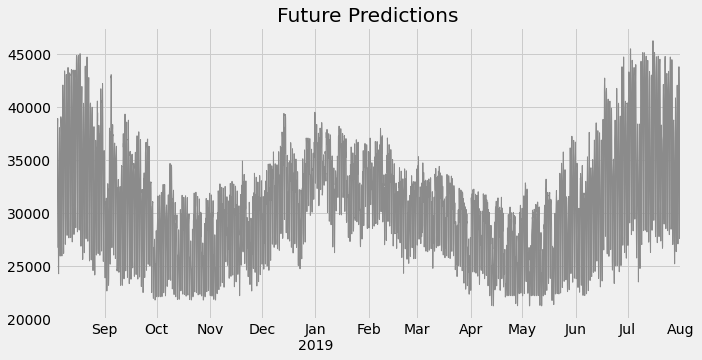

In [144]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [145]:
reg.save_model('model.json')


In [146]:
!ls -lh

total 576K
---------- 1 root root  263 Nov 11 15:53 __notebook_source__.ipynb
-rw-r--r-- 1 root root 572K Nov 11 20:36 model.json


In [147]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')